In [1]:
import os
import os.path as osp
import io
import requests

from enum import Enum
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import display, clear_output

from typing import Optional, Tuple
import random
from tqdm import tqdm

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labelTensor, emojiTensor = torch.load('emojiTensors.pt')

#Extend dataset for faster learning
labelTensor = torch.cat([labelTensor] * 6, dim=0)
emojiTensor = torch.cat([emojiTensor] * 6, dim=0)

dataset = TensorDataset(labelTensor.to(device), emojiTensor.to(device))
trainDataloader = DataLoader(dataset, batch_size=60, shuffle=True)

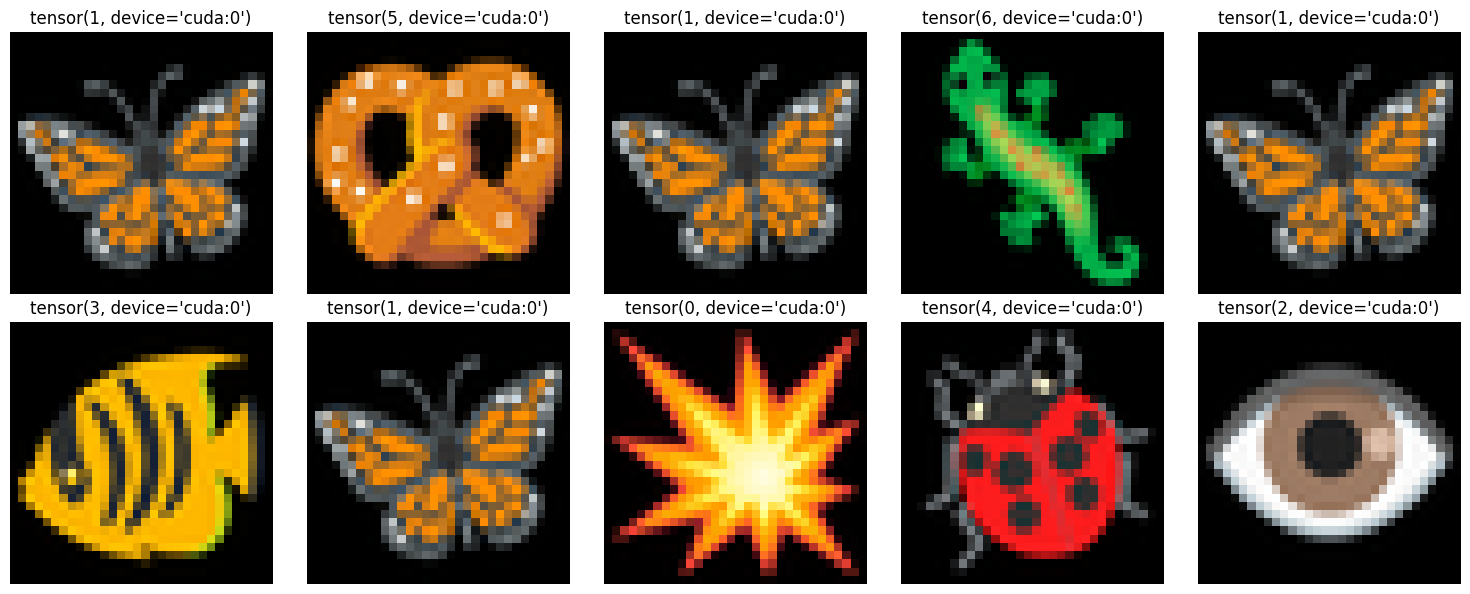

torch.Size([60, 3, 32, 32])


In [3]:
#Make sure correct data is loaded 

labels, batch = next(iter(trainDataloader))
batch_permuted = batch.permute(0, 2, 3, 1).cpu().numpy()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for ax, img, label in zip(axes, batch_permuted, labels):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()
print(batch.shape)

In [4]:
# From https://github.com/shyamsn97/controllable-ncas/blob/master/controllable_nca/nca.py

class UpdateNet(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        zero_bias: bool = True,
    ):
        super(UpdateNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.out = torch.nn.Sequential(
            torch.nn.Conv2d(self.in_channels, 64, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, self.out_channels, 1, bias=False),
        )

        def init_weights(m):
            if isinstance(m, torch.nn.Conv2d):
                if getattr(m, "bias", None) is not None:
                    if zero_bias:
                        torch.nn.init.zeros_(m.bias)

        with torch.no_grad():
            self.apply(init_weights)

    def forward(self, x):
        return self.out(x)

In [5]:
class PerceptionNet(nn.Module):
    def __init__(self, num_channels):
        super(PerceptionNet, self).__init__()

        self.perception_net = torch.nn.Conv2d(
            num_channels,
            num_channels * 3,
            3,
            stride=1,
            padding=1,
            groups=num_channels,
            bias=False,
        )

    def forward(self, x):
        return self.perception_net(x)

In [6]:
# Update net, is the second part. It should take outChannels of the perceptionNet (num_channels *3)
# and out of update net should be actual output channels

In [7]:
class Encoder(nn.Module):
    def __init__(self, num_embeddings, out_channels):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(num_embeddings, out_channels)

    def forward(self, indices):
        embeddings = self.embedding(indices)
        return embeddings

In [49]:
class copiedNCA(nn.Module):
    def __init__(self, device = 'cuda'):
        super(copiedNCA, self).__init__()

        self.num_target_channels = 3
        self.num_goals = 10 # Amount of labels
        self.num_hidden_channels = 16
        self.num_channels = self.num_target_channels + self.num_hidden_channels + 1
        # target_channels + hidden channels + living_channel_dim ~ 3 + 12 + 1 = 16

        self.perception_net = PerceptionNet(self.num_channels).to(device)
        self.update_net = UpdateNet(self.num_channels * 3, self.num_channels).to(device)
        self.living_channel_dim = 3
        self.alpha_living_threshold = 0.1
        self.cell_fire_rate = 0.5
        
        self.encoder = Encoder(self.num_goals, self.num_hidden_channels).to(device)

    #Check what in and out shape of this is
    def alive(self, x):
        return (
            F.max_pool2d(
                x[:, self.living_channel_dim : self.living_channel_dim + 1, :, :],
                kernel_size=3,
                stride=1,
                padding=1,
            )
            > self.alpha_living_threshold
        )

    def get_stochastic_update_mask(self, x):
        return (
            torch.clamp(torch.rand_like(x[:, 0:1], device=x.device), 0.0, 1.0).float()
            < self.cell_fire_rate
        ).float()

    # Goal encoding is my conditioning, What about pre_life mask?
    def update(self, x, goal_encoding, pre_life_mask):
        perceive = self.perception_net(x + goal_encoding * pre_life_mask)
        out = self.update_net(perceive)
        return out

    def forward(self, x, goal_encoding):
        pre_life_mask = self.alive(x)

        rand_mask = self.get_stochastic_update_mask(x)
        out = self.update(x, goal_encoding, pre_life_mask)
        x = x + rand_mask * out

        post_life_mask = self.alive(x)
        life_mask = (pre_life_mask & post_life_mask).float()
        x = x * life_mask
        x = torch.clamp(x, -10.0, 10.0)

        return x, goal_encoding
    

    def generate_seed(
        self,
        num_seeds,
        device: Optional[torch.device] = None,
        size: Optional[int] = None,
    ):
        seed = torch.zeros(
            num_seeds,
            self.num_channels,
            size,
            size,
            device=device,
        )
        seed[
            :, self.living_channel_dim :, size // 2, size // 2
        ] = 1.0  # rgb=0, alpha=1 = black

        # Generates (bs, num_channels, h, w)
        # Where all hidden and living channels have a 1 in their center.

        # But why?
        # 1. Should it not be size num_channels - visible channels?
        # 2. Then 1, repressensts that the pixel is alive right, so shouldn't it only be in the living channel?
        return seed

    def grow(self, x, num_steps, goal):
        goal_encoding = self.encoder(goal).view(x.size(0), -1) # (bs, num_hidden_channels)

        # this adds zeroes in visible and living channels, #(bs, num_channels)
        if goal_encoding.size(-1) == self.num_hidden_channels:
            goal_encoding = F.pad(
                goal_encoding,
                (self.num_channels - self.num_hidden_channels, 0),
            )  # pad initial with zeros
            
        goal_encoding = goal_encoding.view(x.size(0), self.num_channels, 1, 1).repeat(
            1, 1, x.size(-1), x.size(-1)
        ) # (bs, num_channels, h, w)


        for _ in range(num_steps):
            x, goal_encoding = self.forward(x, goal_encoding)
        return x
    
    def loss(self, x, targets):
        return F.mse_loss(
            x[:, : self.num_target_channels, :, :], targets, reduction="none"
        ).mean(dim=(1, 2, 3))
    
nca = copiedNCA(device)
optimizer = optim.Adam(nca.parameters(), lr=1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, [5000], gamma=0.3
)

  0%|          | 1/10000 [00:00<1:29:09,  1.87it/s]

Loss: 0.5558


 10%|█         | 1001/10000 [03:03<28:13,  5.31it/s]

Loss: 0.1359


 20%|██        | 2002/10000 [06:01<24:35,  5.42it/s]

Loss: 0.1285


 30%|███       | 3001/10000 [09:07<21:30,  5.42it/s]

Loss: 0.0589


 40%|████      | 4002/10000 [12:13<17:53,  5.59it/s]

Loss: 0.0570


 50%|█████     | 5002/10000 [15:16<14:49,  5.62it/s]

Loss: 0.0565


 60%|██████    | 6001/10000 [18:22<13:42,  4.86it/s]

Loss: 0.0519


 70%|███████   | 7002/10000 [21:27<09:20,  5.35it/s]

Loss: 0.0387


 80%|████████  | 8002/10000 [24:23<05:49,  5.71it/s]

Loss: 0.0387


 90%|█████████ | 9002/10000 [27:17<02:55,  5.69it/s]

Loss: 0.0369


100%|██████████| 10000/10000 [30:09<00:00,  5.53it/s]


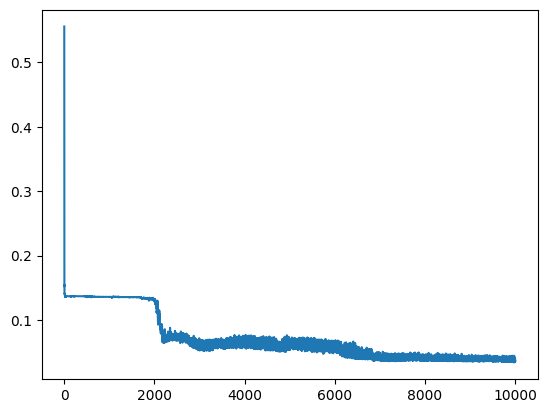

In [50]:
epochs = 10000
printRate = 1000
losslist = []

for i in tqdm(range(epochs)):

    for labels, batch in trainDataloader:
        num_steps = random.randint(48, 96) 

        trainBatch = nca.generate_seed(batch.shape[0], batch.device, batch.shape[-1])
        trainBatch[:, :nca.living_channel_dim] = torch.randn_like(batch) 

        outBatch = nca.grow(trainBatch, num_steps, labels)
        loss = nca.loss(outBatch, batch).mean()
        optimizer.zero_grad()
        loss.backward()

        for p in nca.parameters():
            if p.grad is not None:
                p.grad /= torch.norm(p.grad) + 1e-10
        optimizer.step()
        lr_sched.step()

        losslist.append(loss.item())

    if i % printRate == 0:
        print(f"Loss: {loss.item():.4f}")

plt.plot(losslist)
plt.show()

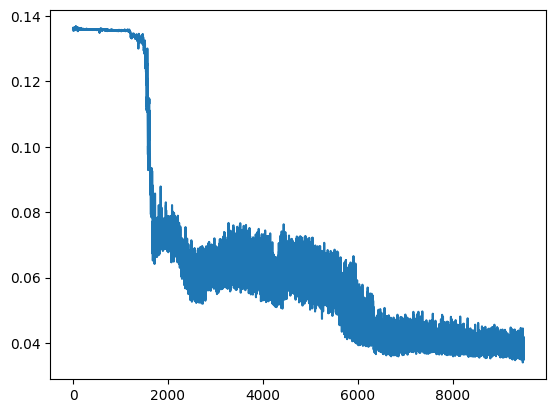

In [51]:
plt.plot(losslist[500:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12708284..1.2300303].


torch.Size([1, 20, 32, 32])


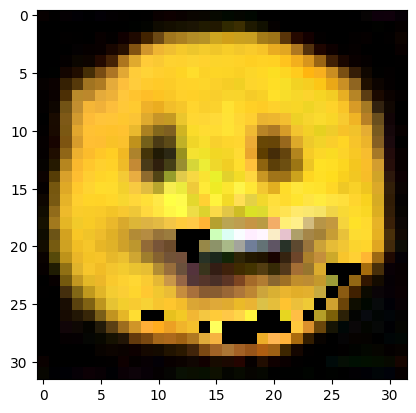

In [65]:
#trainBatch = nca.generate_seed(batch.shape[0], batch.device, batch.shape[0-1])
#trainBatch[:, :nca.living_channel_dim] = torch.randn_like(batch) 

#batch.shape
#labels.shape



tLabel = torch.tensor(7).to(device)
tBatch = nca.generate_seed(1, batch.device, batch.shape[-1]).to(device)
tBatch[:, :nca.living_channel_dim] = torch.randn((1, 3, 32, 32)) 
print(tBatch.shape)

with torch.no_grad():
    outBatch = nca.grow(tBatch, 64, tLabel)

plt.imshow(outBatch[0, :3].permute(1, 2, 0).detach().cpu().numpy())

In [66]:
torch.save(nca.state_dict(), 'copied_model.pth')

In [ ]:
#torch.load('copied_model.pth') ?